# DISTRACTED_DRIVER_CLASSIFIER
AUTHOR: SungwookLE  
DATE: '21.7/13  
PROBLEM: [KAGGLE](https://www.kaggle.com/c/state-farm-distracted-driver-detection)  
REFERENCE: Convolutional Neural Network, [REF](https://www.kaggle.com/abhinavkrjha/using-cnn-architecture-99-631-accuracy)  
  
![gif](https://storage.googleapis.com/kaggle-competitions/kaggle/5048/media/output_DEb8oT.gif)  
Your goal is to predict the likelihood of what the driver is doing in each picture.   
* Class Name:  
c0: safe driving  
c1: texting - right  
c2: talking on the phone - right  
c3: texting - left  
c4: talking on the phone - left  
c5: operating the radio  
c6: drinking  
c7: reaching behind  
c8: hair and makeup  
c9: talking to passenger  

**OVERVIEW**  
1) EDA, Explorative Data Analysis   
2) Feature Engineering (Numerical->Categorical) for Classifier  
3) Modeling  
3-1) train_test_split  
3-2) feed_data preparation (size & dimension)   
3-3) keras: CNN  
4) Model Analysis  
5) Results Test by myself (Optional) 

## START

In [1]:
from subprocess import check_output
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import random

print(check_output(['ls', 'input']).decode('utf8'))

csv_files
driver_imgs_list.csv
imgs
pickle_files
sample_submission.csv
state-farm-distracted-driver-detection.zip



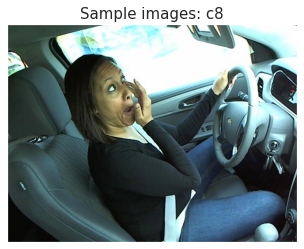

(480, 640, 3)

In [2]:
driver_imgs = pd.read_csv('input/driver_imgs_list.csv')
rand = random.randint(driver_imgs.index[0],driver_imgs.index[-1])
test_img = cv2.imread('input/imgs/train/'+driver_imgs['classname'][rand]+'/'+driver_imgs['img'][rand])
rgb_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img)
plt.xticks([]), plt.yticks([])
plt.title('Sample images: {}'.format(driver_imgs['classname'][rand]), fontsize=15)
plt.show()
rgb_img.shape

## 1. EDA, Explorative Data Analysis and Preparation
We will create a csv file having the location of the files present for training and test images and their associated class if present so that it is easily traceable.

In [3]:
import os

DATA_DIR = "input/imgs"
TEST_DIR = os.path.join(DATA_DIR, "test")
TRAIN_DIR = os.path.join(DATA_DIR, "train")

In [4]:
def create_csv(DATA_DIR, filename):
    class_names = os.listdir(DATA_DIR)
    data = list()
    if(os.path.isdir(os.path.join(DATA_DIR, class_names[0]))):
        for class_name in class_names:
            file_names = os.listdir(os.path.join(DATA_DIR, class_name))
            for file in file_names:
                data.append({
                    "Filename": os.path.join(DATA_DIR, class_name, file),
                    "ClassName": class_name
                })
    
    else:
        class_name = "test"
        file_names = os.listdir(DATA_DIR)
        for file in file_names:
            data.append({
                "Filename": os.path.join(DATA_DIR, file),
                "ClassName": class_name
            })
    
    data = pd.DataFrame(data)
    data.to_csv(os.path.join(os.getcwd(), 'input/csv_files', filename), index=False)

create_csv(TRAIN_DIR, "train_csv")
create_csv(TEST_DIR, "test.csv")

data_train = pd.read_csv('input/csv_files/train_csv')
data_test = pd.read_csv('input/csv_files/test.csv')

In [5]:
data_train.head()

,Filename,ClassName
0,input/imgs/train/c1/img_3055.jpg,c1
1,input/imgs/train/c1/img_89636.jpg,c1
2,input/imgs/train/c1/img_102009.jpg,c1
3,input/imgs/train/c1/img_68418.jpg,c1
4,input/imgs/train/c1/img_7266.jpg,c1


In [6]:
data_test.head()

,Filename,ClassName
0,input/imgs/test/img_59356.jpg,test
1,input/imgs/test/img_92533.jpg,test
2,input/imgs/test/img_4025.jpg,test
3,input/imgs/test/img_43413.jpg,test
4,input/imgs/test/img_2485.jpg,test


In [7]:
data_train.shape, data_test.shape

((22424, 2), (79726, 2))

In [8]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Filename   22424 non-null  object
 1   ClassName  22424 non-null  object
dtypes: object(2)
memory usage: 350.5+ KB


In [9]:
data_train.describe()

,Filename,ClassName
count,22424,22424
unique,22424,10
top,input/imgs/train/c9/img_10755.jpg,c0
freq,1,2489


Text(0, 0.5, 'Count')

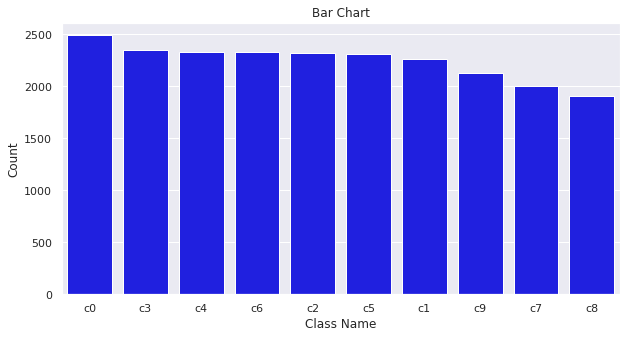

In [10]:
nf = data_train['ClassName'].value_counts().sort_values(ascending=False)
labels = nf.index.tolist()

fig = plt.figure(figsize=(10,5))
sns.barplot(x = labels, y=nf.values, color='blue')

plt.title('Bar Chart')
plt.xlabel('Class Name')
plt.ylabel('Count')

In [11]:
data_test.describe()

,Filename,ClassName
count,79726,79726
unique,79726,1
top,input/imgs/test/img_43155.jpg,test
freq,1,79726


### 1-1. Observation results
1. There are total 22424 training samples  
2. There are total 79726 test samples  
3. The training dataset is equally balanced to a great extent and hence we need not do any downsampling of the data

## 2. Feature Engineering
- Converting into numerical values

In [12]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = dict()
for enum in enumerate(labels_list):
    labels_id.update({enum[1] : enum[0]})

data_train['ClassName']=data_train['ClassName'].map(labels_id)

In [14]:
import pickle
with open(os.path.join(os.getcwd(), 'input/pickle_files', 'labels_list.pkl'), 'wb') as handle:
    pickle.dump(labels_id, handle)

In [13]:
from keras.utils import to_categorical
# to_categorical executes one-hot encoding
labels = to_categorical(data_train['ClassName'])
labels.shape

Using Theano backend.


(22424, 10)

## 3. Modeling
### 3-1. Splitting into Train and Test sets

In [15]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(data_train.iloc[:,0], labels, test_size = 0.2, random_state=42)

In [16]:
ytrain.shape, ytest.shape

((17939, 10), (4485, 10))

### 3-2. Feed_data preparation
- Converting into 64*64 images and modify dimenstion (+batch dimension)  
You can substitute 64,64 to 224,224 for better results only if RAM is > 32gb

In [17]:
from keras.preprocessing import image
from tqdm import tqdm_notebook

def path_to_tensor(img_path):
    # loads RGB images as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(64,64))
    # convert PIL.Image.Image type to 3D tensor with shape (64,64,3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 64, 64, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm_notebook(img_paths)]
    return np.vstack(list_of_tensors)

In [18]:
from PIL import ImageFile
import numpy as np
ImageFile.LOAD_TRUCATED_IMAGES = True

# pre-process the data for Kera and normalize
train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5

/home/joker1251/anaconda3/envs/36py_wooks/lib/python3.6/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/17939 [00:00<?, ?it/s]

In [19]:
# pre-process the data for Kera and normalize
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 -0.5

/home/joker1251/anaconda3/envs/36py_wooks/lib/python3.6/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/4485 [00:00<?, ?it/s]

In [19]:
## Take too much RAM
## run this if your ram is greater than 16gb
# test_tensors = paths_to_tensor(data_test.iloc[:,0]).astype('float32')/255 -0.5

### 3-3. Keras: Defining the Model as CNN

In [20]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
import keras

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score


model = Sequential()
model.add(Conv2D(filters= 64, kernel_size = 2, padding = 'same', activation = 'relu', input_shape=(64,64,3), kernel_initializer ='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size = 2, padding='same', activation = 'relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=256, kernel_size = 2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=512, kernel_size = 2, padding='same', activation ='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       131328    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 512)         524800    
__________

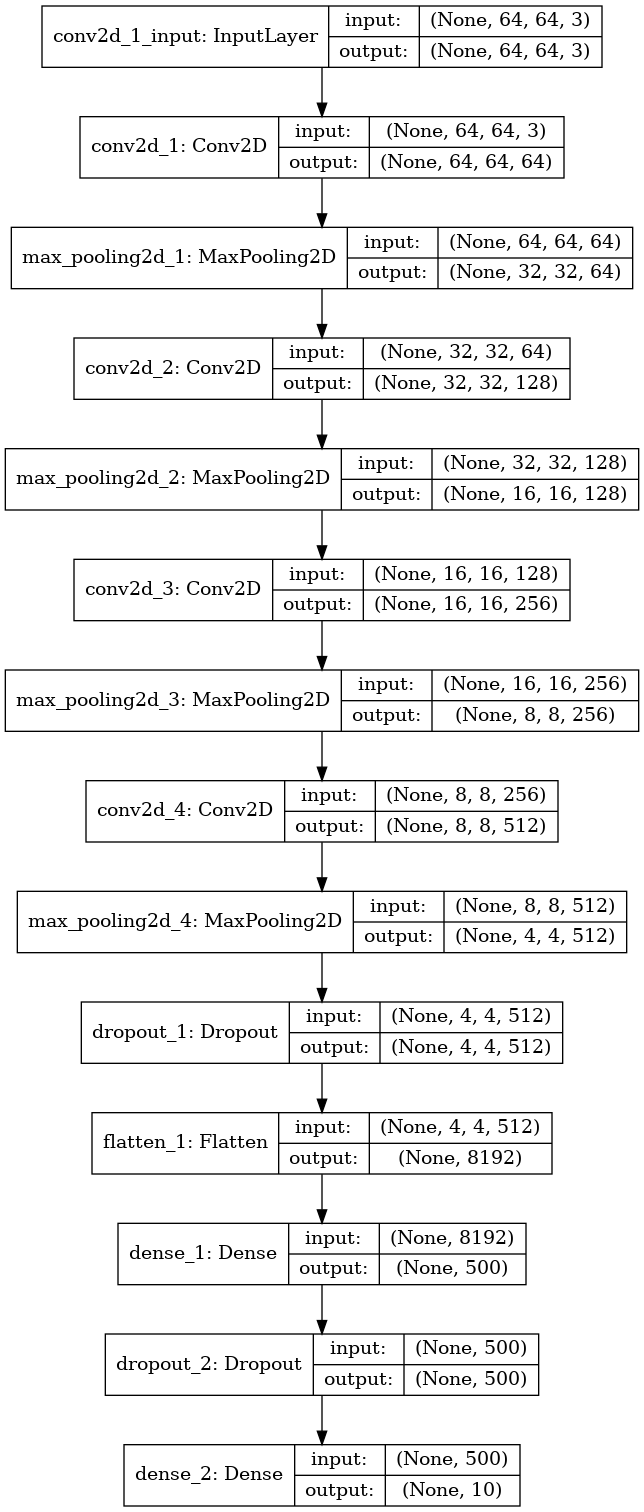

In [21]:
import pydot
keras.utils.vis_utils.pydot = pydot
plot_model(model, to_file = os.path.join('model_distracted_driver.png'), show_shapes=True, show_layer_names=True)
image.load_img('model_distracted_driver.png')

In [22]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
filepath = os.path.join(os.getcwd(),"distracted-{epoch:01d}-{val_acc:.2f}.h5")
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', period=1)
callbacks_list = [checkpoint]

In [25]:
model_history = model.fit(train_tensors, ytrain, validation_data=(valid_tensors, ytest), epochs=5, batch_size=40, shuffle=True, callbacks=callbacks_list)

Train on 17939 samples, validate on 4485 samples
Epoch 1/5
17939/17939 [==============================] - 409s 23ms/step - loss: 1.1817 - acc: 0.5760 - val_loss: 0.2730 - val_acc: 0.9344

Epoch 00001: val_acc improved from -inf to 0.93445, saving model to /home/joker1251/Desktop/owen/DataAnalysis_Kaggle/Distracted_Driver/distracted-1-0.93.h5
Epoch 2/5
17939/17939 [==============================] - 454s 25ms/step - loss: 0.2695 - acc: 0.9194 - val_loss: 0.1072 - val_acc: 0.9692

Epoch 00002: val_acc improved from 0.93445 to 0.96923, saving model to /home/joker1251/Desktop/owen/DataAnalysis_Kaggle/Distracted_Driver/distracted-2-0.97.h5
Epoch 3/5
17939/17939 [==============================] - 490s 27ms/step - loss: 0.1401 - acc: 0.9575 - val_loss: 0.0778 - val_acc: 0.9755

Epoch 00003: val_acc improved from 0.96923 to 0.97547, saving model to /home/joker1251/Desktop/owen/DataAnalysis_Kaggle/Distracted_Driver/distracted-3-0.98.h5
Epoch 4/5
17939/17939 [==============================] - 485

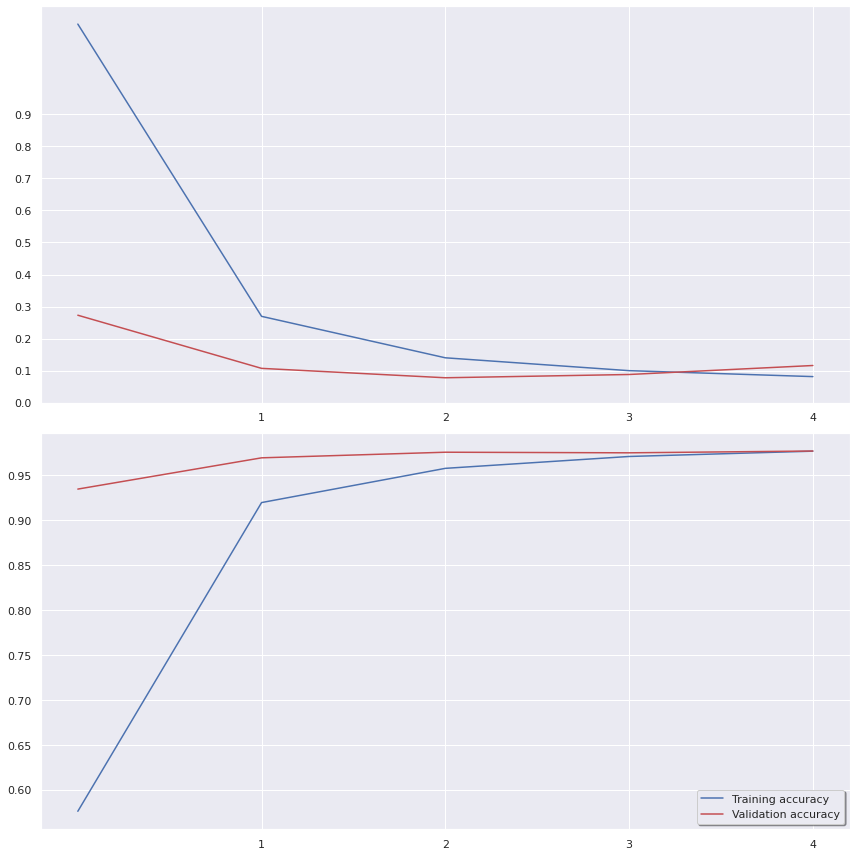

In [37]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,12))
ax1.plot(model_history.history['loss'], color='b', label = 'Training loss')
ax1.plot(model_history.history['val_loss'], color='r', label= 'Validation loss')
ax1.set_xticks(np.arange(1,5,1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['acc'], color ='b', label = 'Training accuracy')
ax2.plot(model_history.history['val_acc'], color = 'r', label = 'Validation accuracy')
ax2.set_xticks(np.arange(1,5,1))

legend = plt.legend(loc= 'best', shadow=True)
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "model_epoch_monitor.png"))
plt.show()

## 4. Model Analysis
Finding the Confusion matrix, Precision, Recall and F1 score to analyse the model thus created

In [27]:
def print_confusion_matrix(confusion_matrix, class_names, figsize=(10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index = class_names, columns = class_names
    )

    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt='d')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    fig.savefig(os.path.join(os.getcwd(), "confusion_matrix.png"))
    return fig

In [28]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels # sess.run(tf.argmax(n_labels,1 ))
    predictions = n_predictions # sess.run(tf.argmax(n_predicitons, 1))

    #confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1), predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis =1)
    w, h = matrix.shape

    c_m = np.zeros((w,h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)

In [29]:
class_names = list()
for name, idx in labels_id.items():
    class_names.append(name)
#print(class_names)
ypred = model.predict(valid_tensors)

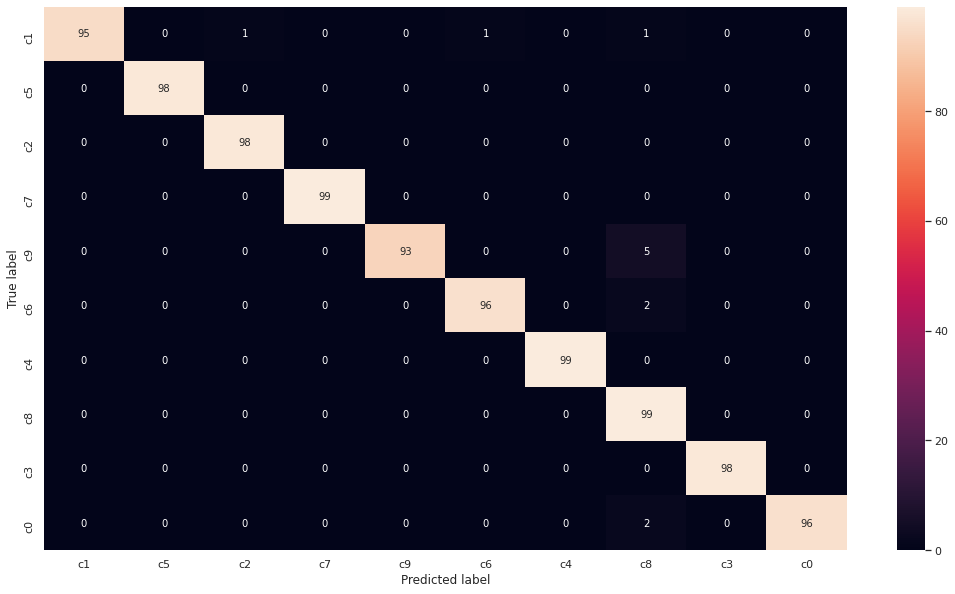

In [30]:
print_heatmap(ytest, ypred, class_names)

### 4-1. Score: Precision Recall F1

In [31]:
ypred_class = np.argmax(ypred,axis=1)
# print(ypred_class[:10])
ytest_class = np.argmax(ytest, axis =1)

In [32]:
accuracy = accuracy_score(ytest_class,ypred_class)
print('Accuracy: {:.4f}'.format(accuracy))
# precision tp / (tp + fp)
precision = precision_score(ytest_class, ypred_class,average='weighted')
print('Precision: {:.4f}'.format(precision))
# recall: tp / (tp + fn)
recall = recall_score(ytest_class,ypred_class,average='weighted')
print('Recall: {:.4f}'.format(recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest_class,ypred_class,average='weighted')
print('F1 score: {:.4f}'.format(f1))

Accuracy: 0.9768
Precision: 0.9785
Recall: 0.9768
F1 score: 0.9771


## 끝

## 5. (Optional) Results Test by myself

In [33]:
import h5py
from keras.models import load_model
# To load the model
model_l=load_model('distracted-5-0.98.h5')

[1] PREDICT ARR: [0.    0.    0.001 0.    0.    0.    0.    0.999 0.    0.   ]
--------------------------------------------------
YES!!!
Correct predict as c8: hair and makeup.

[2] PREDICT ARR: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
--------------------------------------------------
YES!!!
Correct predict as c2: talking on the phone - right.

[3] PREDICT ARR: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
--------------------------------------------------
YES!!!
Correct predict as c3: texting - left.

[4] PREDICT ARR: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
--------------------------------------------------
YES!!!
Correct predict as c6: drinking.

[5] PREDICT ARR: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
--------------------------------------------------
YES!!!
Correct predict as c3: texting - left.

[6] PREDICT ARR: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
--------------------------------------------------
YES!!!
Correct predict as c1: texting - right.



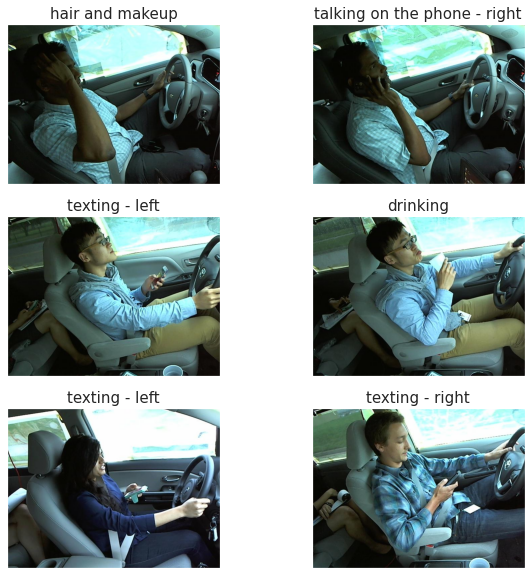

In [34]:
import time
class_dict={'c0': 'safe driving',  
'c1': 'texting - right',  
'c2': 'talking on the phone - right',  
'c3': 'texting - left' , 
'c4': 'talking on the phone - left'  ,
'c5': 'operating the radio'  ,
'c6': 'drinking'  ,
'c7': 'reaching behind',  
'c8': 'hair and makeup',
'c9': 'talking to passenger'}


xtrain_tt = xtrain.reset_index(drop=True)
with open('input/pickle_files/labels_list.pkl', 'rb') as f:
    class_map = pickle.load(f)

fig = plt.figure(figsize=(10,10))
for i in range(6):
    fig.add_subplot(3,2,i+1)
    test_img_idx=random.randint(0, xtrain_tt.shape[0])
    check_img=cv2.imread(xtrain_tt[test_img_idx])
    check_img = cv2.cvtColor(check_img, cv2.COLOR_BGR2RGB)

    for key_label, val_label in enumerate(labels_id):
        if key_label == ytrain[test_img_idx].argmax():
            plt.title(class_dict[val_label], fontsize=15)
            break
    plt.grid(None)
    plt.xticks([]), plt.yticks([])
    plt.imshow(check_img)

    check_img = path_to_tensor(xtrain_tt[test_img_idx]).astype('float32')/255 - 0.5
    check = model_l.predict(check_img)
    
    print('='*50)
    print("[{}] PREDICT ARR: {}".format(i+1,  np.round(check.squeeze(), decimals=3)))
    print('-'*50)
    if (np.equal(key_label, check.argmax())):
        for key, val in class_map.items():
            if (val == ytrain[test_img_idx].argmax() ):
                break

        print('YES!!!\nCorrect predict as {}: {}.'.format(key, class_dict[key] ))
    else:
        for key2, val2 in class_map.items():
            if (val2 == check.argmax()):
                break
        print("NO!\nWrong predict as {}: {}.\nground truth is {}: {}.".format(key2, class_dict[key2], val_label, class_dict[val_label]))
    print('='*50)
    print()

    time.sleep(0.1)

In [35]:
for key, val in class_map.items():
    print(key, val)
print()
for key, val in class_dict.items():
    print(key, val)

c1 0
c5 1
c2 2
c7 3
c9 4
c6 5
c4 6
c8 7
c3 8
c0 9

c0 safe driving
c1 texting - right
c2 talking on the phone - right
c3 texting - left
c4 talking on the phone - left
c5 operating the radio
c6 drinking
c7 reaching behind
c8 hair and makeup
c9 talking to passenger
